# Feed Forward

In [1]:
from jaxfluids import InputManager, InitializationManager, SimulationManager

input_manager = InputManager("sod.json", "numerical_setup.json")
init_manager = InitializationManager(input_manager)
sim_manager = SimulationManager(input_manager)

jxf_buffers = init_manager.initialization()
sim_manager.simulate(jxf_buffers)

*------------------------------------------------------------------------------*
*                                                                              *
*                                                                              *
*          _     _    __  __        _____  _      _   _  ___  ____   ____      *
*         | |   / \   \ \/ /       |  ___|| |    | | | ||_ _||  _ \ / ___|     *
*      _  | |  / _ \   \  /  _____ | |_   | |    | | | | | | | | | |\___ \     *
*     | |_| | / ___ \  /  \ |_____||  _|  | |___ | |_| | | | | |_| | ___) |    *
*      \___/ /_/   \_\/_/\_\       |_|    |_____| \___/ |___||____/ |____/     *
*                                                                              *
*                                By BB - ML@AER                                *
*                                                                              *
*------------------------------------------------------------------------------*
* JAX-FLUIDS -              

True

Loading time snapshot 2.0000e-01


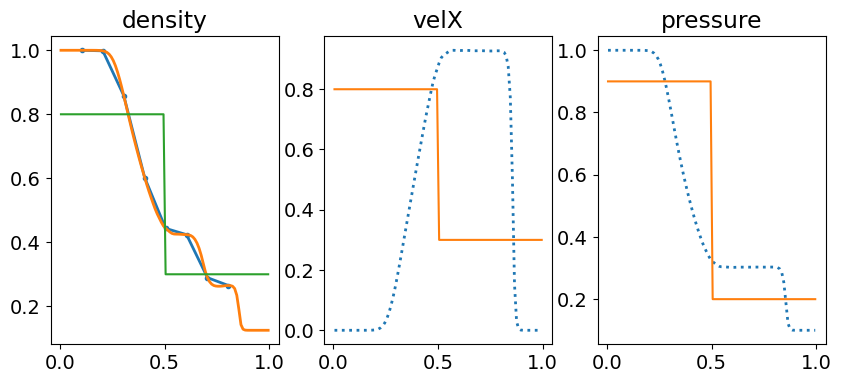

In [17]:
from jaxfluids_postprocess import load_data
jxf_data = load_data("results/sod-6", quantities=["density", "velocity", "pressure"], start=-1)

x, y, z = jxf_data.cell_centers
data = jxf_data.data
density_ref = data["density"].squeeze()
velX_ref = data["velocity"][:,0].squeeze()
pressure_ref = data["pressure"].squeeze()

x = x.squeeze()

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(ncols=3, figsize=(10,4))
ax[0].plot(x[10:-10:10], density_ref[10:-10:10], linestyle="-", marker=".", linewidth=2)
ax[0].plot(x, density_ref, linestyle="-", linewidth=2)
ax[0].plot(x, np.where(x < 0.5, 0.8, 0.3))
ax[1].plot(x, velX_ref, linestyle=":", linewidth=2)
ax[1].plot(x, np.where(x < 0.5, 0.8, 0.3))
ax[2].plot(x, pressure_ref, linestyle=":", linewidth=2)
ax[2].plot(x, np.where(x < 0.5, 0.9, 0.2))
labels = ("density", "velX", "pressure")
for i, axi in enumerate(ax):
    axi.set_title(labels[i])


In [23]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import Array

from jaxfluids.feed_forward.data_types import FeedForwardSetup

feed_forward_setup = FeedForwardSetup(
    outer_steps=200,
    inner_steps=1,
    is_include_halos=False
)

def initial_condition(params: Array, x: Array) -> Array:
    density_0   = jnp.where(x < 0.5, params[0], params[1])
    velocityX_0 = jnp.where(x < 0.5, params[2], params[3])
    pressure_0  = jnp.where(x < 0.5, params[4], params[5])
    init_buffer = jnp.stack([
        density_0,
        velocityX_0,
        jnp.zeros_like(velocityX_0),
        jnp.zeros_like(velocityX_0),
        pressure_0
    ], axis=0)

    return init_buffer

def loss_fn(params: Array, x: Array) -> float:
    init_cond = initial_condition(params, x)

    data, times = sim_manager._feed_forward(
        init_cond,
        1e-03,
        0.0,
        feed_forward_setup,
    )
    primitives_0 = data["primitives"][0].squeeze()
    primitives = data["primitives"][-1].squeeze()
    density_0, velX_0, _, _, pressure_0 = primitives_0
    density, velX, _, _, pressure = primitives

    s_ = jnp.s_[10:-10:10]
    s_ = jnp.s_[:]

    loss = jnp.mean((density[s_] - density_ref[s_])**2) \
        + 0.0 * jnp.mean((velX[s_] - velX_ref[s_])**2) \
        + 0.0 * jnp.mean((pressure[s_] - pressure_ref[s_])**2)
    
    return loss, (density, velX, pressure, density_0, velX_0, pressure_0)


In [24]:
x, y, z = sim_manager.domain_information.get_device_cell_centers()

In [28]:
params = jnp.array([1.0,1.0,1.0,1.0,1.0,1.0,0.6])
#params = jnp.array([1.0,0.125,0.0,0.0,1.0,0.1])
#loss_fn(params, x)

loss_fn = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))
loss_fn(params, x)

TypeError: Gradient only defined for scalar-output functions. Output was (Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, (Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace>, Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace>, Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace>, Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace>, Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace>, Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace>)).

In [26]:
import matplotlib.pyplot as plt

def lr_schedule(itr):
    if itr < 50:
        return 0.2
    elif itr < 200:
        return 0.1
    else:
        return 0.01

In [27]:
params = jnp.array([1.0,1.0,0.0,0.0,1.0,1.0])
# params = jnp.array([1.0,0.125,0.0,0.0,1.0,0.1])

for itr in range(1000):
    (loss, (density, velX, pressure, density_0, velX_0, pressure_0)), grad = loss_fn(params, x)
    
    lr = lr_schedule(itr)
    params -= lr * grad

    if itr % 25 == 0:
        print(f"{itr:04d}, {loss:3.2e}, {params}")
        fig, ax = plt.subplots(ncols=3, figsize=(12,4))
        ax[0].plot(x.squeeze(), density)
        ax[0].plot(x.squeeze(), density_0, linestyle="--")
        ax[0].plot(x.squeeze(), density_ref, linestyle=":")
        ax[1].plot(x.squeeze(), velX)
        ax[1].plot(x.squeeze(), velX_0, linestyle="--")
        ax[1].plot(x.squeeze(), velX_ref, linestyle=":")
        ax[2].plot(x.squeeze(), pressure, label="jxf tn")
        ax[2].plot(x.squeeze(), pressure_0, linestyle="--", label="jxf t0")
        ax[2].plot(x.squeeze(), pressure_ref, linestyle=":", label="ref")
        ax[2].legend()
        for axi in ax:
            axi.set_box_aspect(1.0)
        plt.savefig(f"image_{itr:04d}.png", bbox_inches="tight", dpi=400)
        plt.close()

0000, 2.96e-01, [ 0.96864796  0.85635204 -0.03757036  0.03757036  0.99029956  1.00970044]
0025, 1.53e-02, [ 0.92108319  0.29352448 -0.22227863  0.12900049  0.98551463  1.01414165]
0050, 1.41e-02, [ 0.9477967   0.29231462 -0.28430789  0.13777411  1.00720304  0.98786903]
0075, 1.37e-02, [ 0.95826474  0.29289374 -0.30754608  0.14070944  1.0154348   0.97590301]
0100, 1.35e-02, [ 0.96703743  0.29323992 -0.32646811  0.1428794   1.02232072  0.96469711]
0125, 1.33e-02, [ 0.97439351  0.29338123 -0.34183176  0.1443919   1.02815201  0.9541038 ]
0150, 1.32e-02, [ 0.98058665  0.29334472 -0.35424819  0.14534584  1.03312182  0.94400027]
0175, 1.31e-02, [ 0.98581396  0.29315662 -0.36421448  0.14582872  1.03736587  0.93427554]
0200, 1.30e-02, [ 0.99008208  0.29286348 -0.37187827  0.14593029  1.0408846   0.92515028]
0225, 1.30e-02, [ 0.99048564  0.2928265  -0.37257547  0.14592179  1.04121987  0.92421525]
0250, 1.30e-02, [ 0.99088237  0.29278954 -0.37325344  0.14591142  1.04155236  0.9232793 ]
0275, 1.30